In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import h5py 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random
import copy 
from scipy.io import savemat
from sklearn import metrics as skmetric

## Load datasets
1. Load noisy datasets to train the mimmax_scaler
2. Load clean data to train MLPclean
3. Load noisy data to train MLPnoisy

In [2]:
all_snrs= np.arange(-20.0, 11, 5)
all_snrs= np.append(all_snrs, np.inf)
snr_training_weights= np.flip(len(all_snrs)-np.arange(len(all_snrs)))/len(all_snrs)
# snr_training_weights = np.ones(all_snrs.shape)
print(snr_training_weights)

root_data_dir= '../Datasets/psd_gp_vIHC_mat/PyData/'

# Load clean data 
train_test_dataset = h5py.File(root_data_dir + 'PSD_data_clean.h5', "r")
data_x_clean_orig = np.array(train_test_dataset["data_psd_x"][:]) # your train set features
data_y_clean_orig = np.ravel(np.array(train_test_dataset["data_label_y"][:])) # your train set labels
# data_clean_fnames = np.ravel(np.array(train_test_dataset["data_filename"][:])) # your train set labels
call_label_code = ['Chut', 'Rumble', 'Wheek', 'Whine', 'Other']

train_inds, test_inds = train_test_split(np.arange(data_x_clean_orig.shape[0]), test_size=0.25, random_state=1)

all_train_x_orig = data_x_clean_orig[train_inds,:]
all_train_y_orig = data_y_clean_orig[train_inds]

# Load all SNR data 
for snr_value,snr_weight in zip(all_snrs[0:-1], snr_training_weights[0:-1]):
    print(f"SNR={snr_value} dB and weight = {snr_weight}")
    out_psd_data_file = root_data_dir + 'PSD_data_SNR' + snr_value.astype('int').astype('str') + '.h5'    
    cur_dataset = h5py.File(out_psd_data_file, "r")
        
    cur_x = np.array(cur_dataset["data_psd_x"][:])
    cur_y = np.ravel(np.array(cur_dataset["data_label_y"][:]))
    
    if snr_weight is 1:
        sample_inds_training, _= train_test_split(np.arange(len(train_inds)), test_size= 1-snr_weight, random_state=1)
    else:
        sample_inds_training = np.ones(train_inds.shape)==1


    all_train_x_orig = np.concatenate((all_train_x_orig, cur_x[train_inds[sample_inds_training],:]), axis=0)
    all_train_y_orig = np.concatenate((all_train_y_orig, cur_y[train_inds[sample_inds_training]]))
    
    unq_vals, unq_counts = np.unique(cur_y[train_inds[sample_inds_training]], return_counts=True)
    print(dict(zip(unq_vals,unq_counts)))    

    # print(f"shape:cur={cur_x.shape},cur_subsamp={len(sample_inds_training)}, full={len(train_inds)}, all_train_x_orig={all_train_x_orig.shape},type={type(cur_x)}")

minmax_scaler = MinMaxScaler()
minmax_scaler.fit(all_train_x_orig)

clean_train_x_norm = minmax_scaler.transform(data_x_clean_orig)
all_train_x_norm = minmax_scaler.transform(all_train_x_orig)

X_train_clean, X_test_clean, y_train_clean, y_test_clean, train_inds, test_inds = train_test_split \
    (clean_train_x_norm, data_y_clean_orig, np.arange(clean_train_x_norm.shape[0]), test_size=0.25, random_state=1)
print(f"Type: X_train_clean={type(X_train_clean)}, y_train_clean={type(y_train_clean)}")
print(f"Shapes: X_train_clean={X_train_clean.shape}, y_train_clean={y_train_clean.shape}, X_test_clean={X_test_clean.shape}, y_test_clean={y_test_clean.shape}")

unq_vals, unq_counts = np.unique(all_train_y_orig, return_counts=True)
print(dict(zip(unq_vals,unq_counts)))

[0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.   ]
SNR=-20.0 dB and weight = 0.125
{0: 327, 1: 191, 2: 285, 3: 328, 4: 72}
SNR=-15.0 dB and weight = 0.25
{0: 327, 1: 191, 2: 285, 3: 328, 4: 72}
SNR=-10.0 dB and weight = 0.375
{0: 327, 1: 191, 2: 285, 3: 328, 4: 72}
SNR=-5.0 dB and weight = 0.5
{0: 327, 1: 191, 2: 285, 3: 328, 4: 72}
SNR=0.0 dB and weight = 0.625
{0: 327, 1: 191, 2: 285, 3: 328, 4: 72}
SNR=5.0 dB and weight = 0.75
{0: 327, 1: 191, 2: 285, 3: 328, 4: 72}
SNR=10.0 dB and weight = 0.875
{0: 327, 1: 191, 2: 285, 3: 328, 4: 72}
Type: X_train_clean=<class 'numpy.ndarray'>, y_train_clean=<class 'numpy.ndarray'>
Shapes: X_train_clean=(1203, 67), y_train_clean=(1203,), X_test_clean=(402, 67), y_test_clean=(402,)
{0: 2616, 1: 1528, 2: 2280, 3: 2624, 4: 576}


<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\spsat\AppData\Local\Temp\ipykernel_3276\345257347.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if snr_weight is 1:


## Model #1: An SVM model (rbf kernels seem to work the best)

Unique values in y_test_pred=[0 1 2 3 4]
Unique values in y_train_clean=[0 1 2 3 4]
Training accuracy=0.9650872817955112
 Testing accuracy=0.9626865671641791



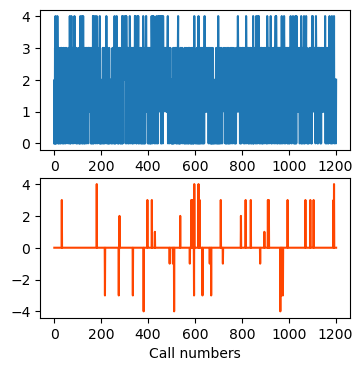

In [83]:
svm_model = svm.SVC(kernel='rbf').fit(X_train_clean, y_train_clean)
y_train_pred = svm_model.predict(X_train_clean)
y_test_pred = svm_model.predict(X_test_clean)

print(f"Unique values in y_test_pred={np.unique(y_test_pred)}")
print(f"Unique values in y_train_clean={np.unique(y_train_clean)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_clean)
ax[1].plot(y_train_clean-y_train_pred, color = "orangered")
ax[1].set_xlabel("Call numbers")

print(f"Training accuracy={np.sum(y_train_clean==y_train_pred)/len(y_train_pred)}\n Testing accuracy={np.sum(y_test_clean==y_test_pred)/len(y_test_pred)}\n")

## Model #2. Train an MLP using clean data

In [84]:
import os 
# tf.random.set_random_seed(1234)  # applied to achieve consistent results
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
MLPclean = Sequential(
    [
        Dense(10, activation = 'relu',   name = "L1"),
        Dense(5, activation = 'linear', name = "L2")
    ]
)

# Compile the model 
MLPclean.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
)

# Fit the model 
MLPclean.fit(
    X_train_clean,y_train_clean,
    epochs=200
)

clean_MLP_fName = root_data_dir + 'PSD_cleanMLP.h5'

if not os.path.exists(clean_MLP_fName):
    MLPclean.save(clean_MLP_fName)
    print(f"Saved {clean_MLP_fName} successfully.")
else: 
    print(f"File {clean_MLP_fName} is already saved.")

Train on 1203 samples
Epoch 1/200
1203/1203 [==============================] - 0s 195us/sample - loss: 0.9349
Epoch 2/200
1203/1203 [==============================] - 0s 23us/sample - loss: 0.3727
Epoch 3/200
1203/1203 [==============================] - 0s 23us/sample - loss: 0.2471
Epoch 4/200
1203/1203 [==============================] - 0s 24us/sample - loss: 0.2078
Epoch 5/200
1203/1203 [==============================] - 0s 25us/sample - loss: 0.1884
Epoch 6/200
1203/1203 [==============================] - 0s 24us/sample - loss: 0.1767
Epoch 7/200
1203/1203 [==============================] - 0s 24us/sample - loss: 0.1744
Epoch 8/200
1203/1203 [==============================] - 0s 24us/sample - loss: 0.1581
Epoch 9/200
1203/1203 [==============================] - 0s 25us/sample - loss: 0.1490
Epoch 10/200
1203/1203 [==============================] - 0s 25us/sample - loss: 0.1438
Epoch 11/200
1203/1203 [==============================] - 0s 25us/sample - loss: 0.1455
Epoch 12/200
1203/

## Test MLP accuracy for training and testing 

Unique values in y_train_clean=[0 1 2 3 4]
Unique values in y_test_pred=[0 1 2 3 4]
Training accuracy=0.9858686616791354
 Testing accuracy=0.9751243781094527



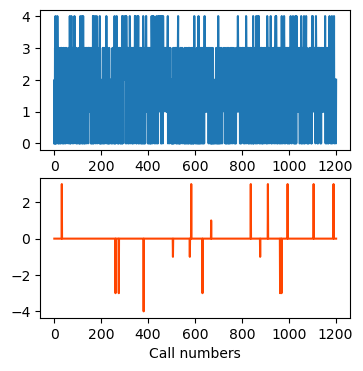

<Figure size 640x480 with 0 Axes>

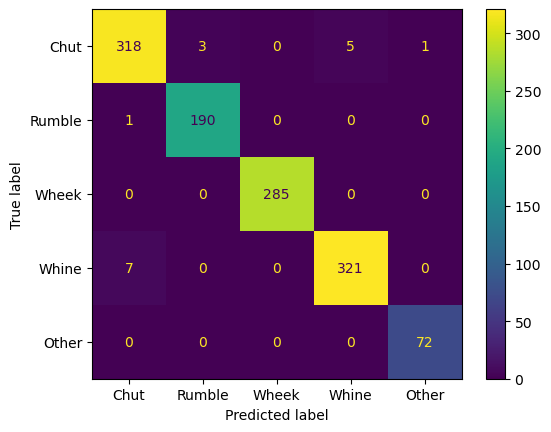

In [85]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_train_pred_NN_clean = np.argmax(MLPclean.predict(X_train_clean), axis=1)
y_test_pred_NN_clean = np.argmax(MLPclean.predict(X_test_clean), axis=1)

print(f"Unique values in y_train_clean={np.unique(y_train_pred_NN_clean)}")
print(f"Unique values in y_test_pred={np.unique(y_test_pred_NN_clean)}")

fig, ax = plt.subplots(2,1,figsize=(4,4))
ax[0].plot(y_train_clean)
ax[1].plot(y_train_clean-y_train_pred_NN_clean, color = "orangered")
ax[1].set_xlabel("Call numbers")

train_accuracy_cleanMLP = np.sum(y_train_clean==y_train_pred_NN_clean)/len(y_train_clean)

print(f"Training accuracy={train_accuracy_cleanMLP}\n Testing accuracy={np.sum(y_test_clean==y_test_pred_NN_clean)/len(y_test_clean)}\n")

# confusion_matrix(y_train_clean, y_train_pred_NN_clean, labels=conf_labels)
cnf_matrix = confusion_matrix(y_train_clean, y_train_pred_NN_clean)

plt.figure(num=2)
disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=call_label_code)
disp.plot()
plt.show()

## Model #3. MLP cleaned on noisy calls 

In [86]:
# tf.random.set_random_seed(1234)  # applied to achieve consistent results
tf.random.set_seed(1234)  # applied to achieve consistent results

# Define the model 
MLPnoisy = Sequential(
    [
        Dense(10, activation = 'relu',   name = "L1"),
        Dense(5, activation = 'linear', name = "L2")
    ]
)

# Compile the model 
MLPnoisy.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(0.01),
    metrics=['accuracy'],
)

# Fit the model 
MLPnoisy.fit(
    all_train_x_norm, all_train_y_orig,
    epochs=100
)

noisy_MLP_fName = root_data_dir + 'PSD_noisyMLP.h5'
if not os.path.exists(noisy_MLP_fName):
    MLPnoisy.save(noisy_MLP_fName)
    print(f"Saved {noisy_MLP_fName} successfully.")
else: 
    print(f"File {noisy_MLP_fName} is already saved.")

Train on 9624 samples
Epoch 1/100
9624/9624 [==============================] - 0s 50us/sample - loss: 0.8735 - accuracy: 0.6648
Epoch 2/100
9624/9624 [==============================] - 0s 27us/sample - loss: 0.5893 - accuracy: 0.7892
Epoch 3/100
9624/9624 [==============================] - 0s 26us/sample - loss: 0.5208 - accuracy: 0.8134
Epoch 4/100
9624/9624 [==============================] - 0s 24us/sample - loss: 0.4800 - accuracy: 0.8292
Epoch 5/100
9624/9624 [==============================] - 0s 24us/sample - loss: 0.4572 - accuracy: 0.8347
Epoch 6/100
9624/9624 [==============================] - 0s 24us/sample - loss: 0.4362 - accuracy: 0.8423
Epoch 7/100
9624/9624 [==============================] - 0s 24us/sample - loss: 0.4242 - accuracy: 0.8450
Epoch 8/100
9624/9624 [==============================] - 0s 26us/sample - loss: 0.4178 - accuracy: 0.8477
Epoch 9/100
9624/9624 [==============================] - 0s 25us/sample - loss: 0.4090 - accuracy: 0.8517
Epoch 10/100
9624/9624 [

## Test in different SNRs 

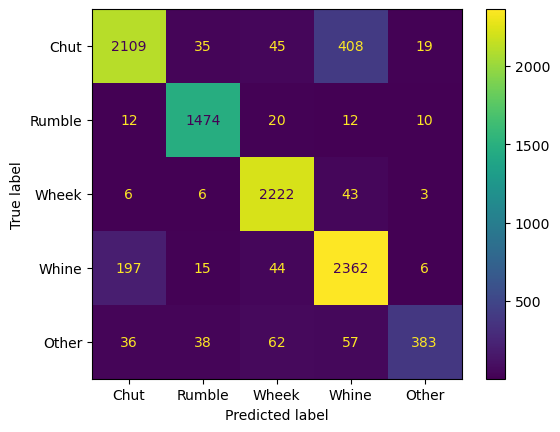

<HDF5 file "PSD_data_SNR-20.h5" (mode r)>
<HDF5 file "PSD_data_SNR-20.h5" (mode r)>


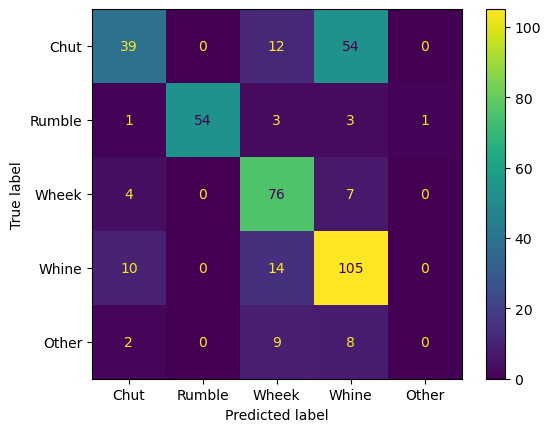

SNR=-20.0 dB | Accuracy= clean = 0.2860696517412935, noisy = 0.681592039800995
<HDF5 file "PSD_data_SNR-15.h5" (mode r)>
<HDF5 file "PSD_data_SNR-15.h5" (mode r)>


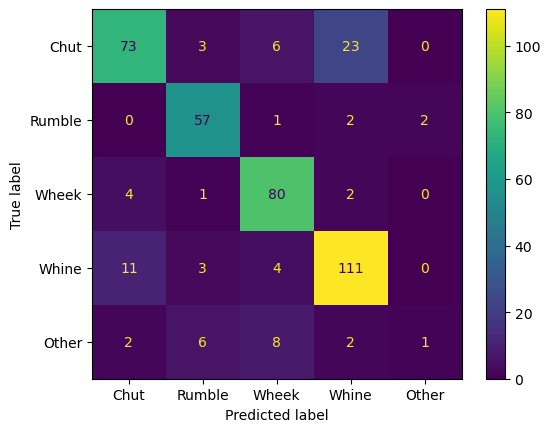

SNR=-15.0 dB | Accuracy= clean = 0.2537313432835821, noisy = 0.8009950248756219
<HDF5 file "PSD_data_SNR-10.h5" (mode r)>
<HDF5 file "PSD_data_SNR-10.h5" (mode r)>


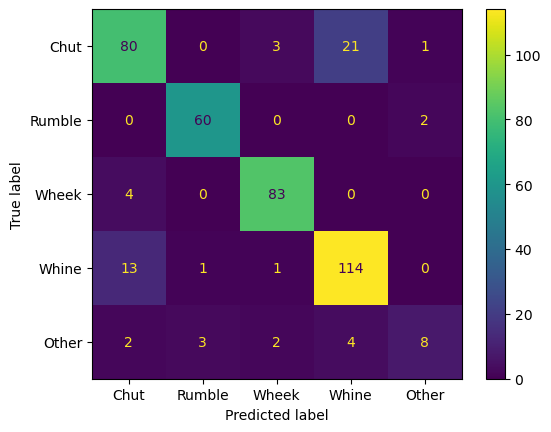

SNR=-10.0 dB | Accuracy= clean = 0.31592039800995025, noisy = 0.8582089552238806
<HDF5 file "PSD_data_SNR-5.h5" (mode r)>
<HDF5 file "PSD_data_SNR-5.h5" (mode r)>


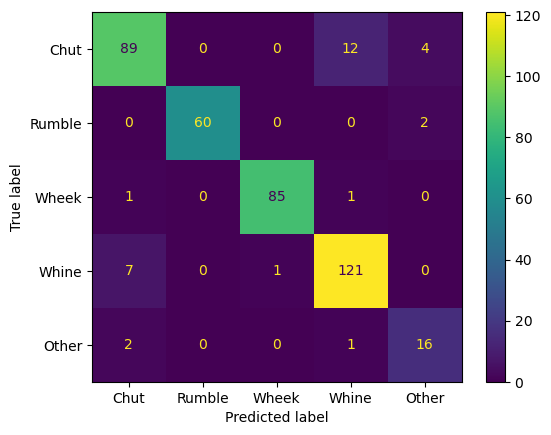

SNR=-5.0 dB | Accuracy= clean = 0.4129353233830846, noisy = 0.9228855721393034
<HDF5 file "PSD_data_SNR0.h5" (mode r)>
<HDF5 file "PSD_data_SNR0.h5" (mode r)>


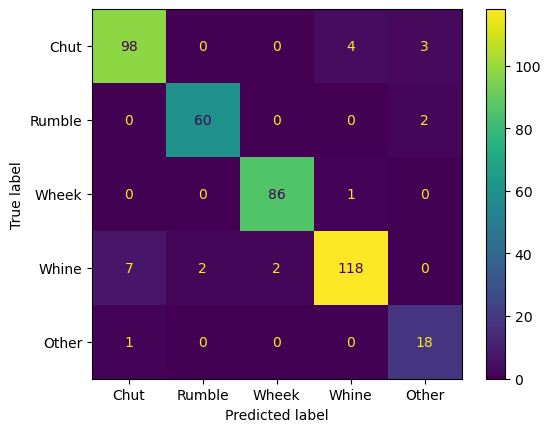

SNR=0.0 dB | Accuracy= clean = 0.5572139303482587, noisy = 0.945273631840796
<HDF5 file "PSD_data_SNR5.h5" (mode r)>
<HDF5 file "PSD_data_SNR5.h5" (mode r)>


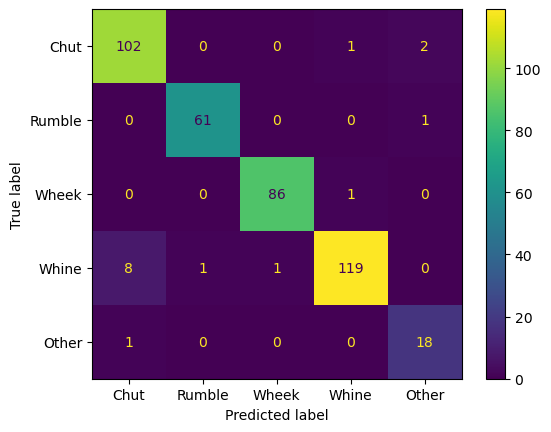

SNR=5.0 dB | Accuracy= clean = 0.753731343283582, noisy = 0.9601990049751243
<HDF5 file "PSD_data_SNR10.h5" (mode r)>
<HDF5 file "PSD_data_SNR10.h5" (mode r)>


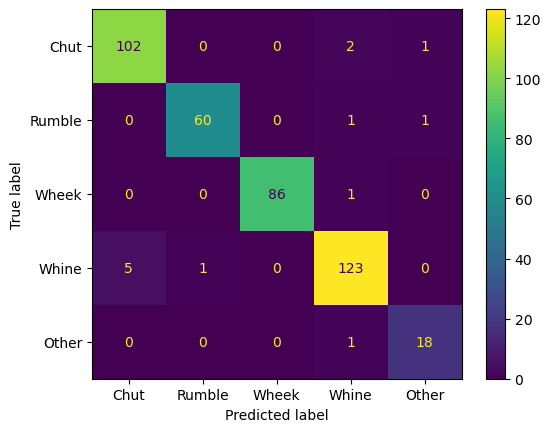

SNR=10.0 dB | Accuracy= clean = 0.9353233830845771, noisy = 0.9676616915422885
<HDF5 file "PSD_data_clean.h5" (mode r)>
<HDF5 file "PSD_data_clean.h5" (mode r)>


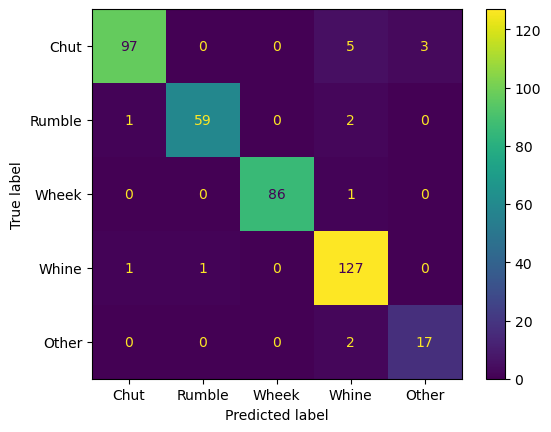

SNR=inf dB | Accuracy= clean = 0.9751243781094527, noisy = 0.9601990049751243


In [87]:
def plot_conf_matrix(label_true, label_est, display_labels):
    cnf_matrix = confusion_matrix(label_true, label_est)
    disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=display_labels)
    disp.plot()
    plt.show()    


def test_MLP_snr(MLPmodel, minmax_scaler, snr_value, test_inds_clean):
    root_out_dir= '../Datasets/psd_gp_vIHC_mat/PyData/'
    if np.isinf(snr_value):
        out_psd_data_file = root_out_dir + 'PSD_data_clean.h5'
    else:
        out_psd_data_file = root_out_dir + 'PSD_data_SNR' + snr_value.astype('int').astype('str') + '.h5'
    cur_snr_dataset = h5py.File(out_psd_data_file, "r")
    print(cur_snr_dataset)
    data_x_orig = np.array(cur_snr_dataset["data_psd_x"][:]) # your train set features
    data_y_orig = np.ravel(np.array(cur_snr_dataset["data_label_y"][:])) # your train set labels
    # data_fnames = np.ravel(np.array(cur_snr_dataset["data_filename"][:])) # your train set labels
    data_x_norm = minmax_scaler.transform(data_x_orig)

    X_test = data_x_norm[test_inds]
    y_test = data_y_orig[test_inds]
    # fName_test= data_fnames[test_inds]

    # print(f"-------------------\nWorking on SNR = {snr_value} dB\n--------------------------------------")
    # for fileNum,fileName in zip(range(len(fName_test[:5])),fName_test[:5]):
    #     print(f"File #{fileNum}: {fileName}")
    
    # rand_int = random.randint(0, len(test_fnames_clean))
    # clean_name = test_fnames_clean[rand_int].decode("utf-8")
    # noisy_name= fName_test[rand_int].decode("utf-8")

    # # print(f"file number={rand_int} |-| clean={clean_name}|noisy={noisy_name}")
    # clean_name= clean_name[clean_name.rfind('/')+1:-3]
    # noisy_name= noisy_name[noisy_name.rfind('/')+1:-3]
    # if clean_name!=noisy_name:
    #     print("Should be same")
    
    y_test_pred_NN = np.argmax(MLPmodel.predict(X_test), axis=1)
    accuracy = np.sum(y_test==y_test_pred_NN)/len(y_test)
    # auc = skmetric.roc_auc_score(y_test, y_test_pred_NN)
    # accuracy = skmetric.accuracy_score(y_test, y_test_pred_NN)
    # print(f"[SNR={snr_value} dB] Accuracy={accuracy}\n")
        
    return accuracy,y_test_pred_NN,y_test

y_train_pred_NN_noisy = np.argmax(MLPnoisy.predict(all_train_x_norm), axis=1)
train_accuracy_noisyMLP = np.sum(all_train_y_orig==y_train_pred_NN_noisy)/len(all_train_y_orig)

plot_conf_matrix(all_train_y_orig, y_train_pred_NN_noisy, display_labels=call_label_code)

test_accuracy_cleanMLP = np.zeros(all_snrs.shape)
test_accuracy_noisyMLP = np.zeros(all_snrs.shape)
# test_auc_cleanMLP = np.zeros(all_snrs.shape)
# test_auc_noisyMLP = np.zeros(all_snrs.shape)

for snr_value,iter in zip(all_snrs,range(len(all_snrs))):
    test_accuracy_cleanMLP[iter],y_pred_clean,y_true_clean= test_MLP_snr(MLPclean, minmax_scaler, snr_value, test_inds)
    # plot_conf_matrix(y_true_clean, y_pred_clean, display_labels=call_label_code)
    
    test_accuracy_noisyMLP[iter],y_pred_noisy,y_true_noisy= test_MLP_snr(MLPnoisy, minmax_scaler, snr_value, test_inds)
    plot_conf_matrix(y_true_noisy, y_pred_noisy, display_labels=call_label_code)
    print(f"SNR={snr_value} dB | Accuracy= clean = {test_accuracy_cleanMLP[iter]}, noisy = {test_accuracy_noisyMLP[iter]}")

## Plot results 

([<matplotlib.axis.XTick at 0x1d839d3e6a0>,
 [Text(-20.0, 0, '-20'),
  Text(-15.0, 0, '-15'),
  Text(-10.0, 0, '-10'),
  Text(-5.0, 0, '-5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, ''),
  Text(20.0, 0, '$\\infty$'),
  Text(25.0, 0, ''),
  Text(30.0, 0, 'Training')])

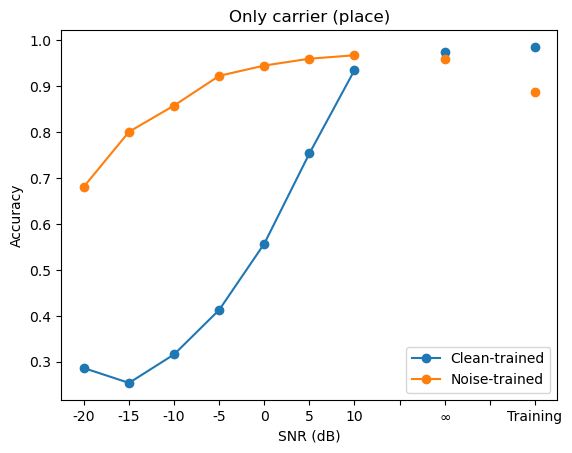

In [88]:
plot_snr= copy.deepcopy(all_snrs)
plot_snr[np.isinf(plot_snr)] = 20
plot_snr = np.append(plot_snr[:-1], [15, plot_snr[-1], 25, 30])
plot_snr_label = [str(item.astype('int')) for item in plot_snr[:-4]] + [''] + ['$\infty$'] + [''] + ['Training']
plt_accuracy_clean = np.append(test_accuracy_cleanMLP[:-1], [np.nan, test_accuracy_cleanMLP[-1], np.nan, train_accuracy_cleanMLP])
plt_accuracy_noisy = np.append(test_accuracy_noisyMLP[:-1], [np.nan, test_accuracy_noisyMLP[-1], np.nan, train_accuracy_noisyMLP])

plt.plot(plot_snr, plt_accuracy_clean, 'o-', label="Clean-trained")
plt.plot(plot_snr, plt_accuracy_noisy, 'o-', label="Noise-trained")
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.title("Only carrier (place)")
plt.legend(loc='lower right')
plt.xticks(ticks=plot_snr, labels=plot_snr_label)

In [89]:
out_PSDvIHC_classify_file = root_data_dir + 'PSDvIHC_classify_out'

np.savez(out_PSDvIHC_classify_file + '.npz', all_snrs=all_snrs, \
    train_accuracy_cleanMLP=train_accuracy_cleanMLP, train_accuracy_noisyMLP=train_accuracy_noisyMLP,\
    test_accuracy_cleanMLP=test_accuracy_cleanMLP, test_accuracy_noisyMLP=test_accuracy_noisyMLP)

mat_dict= {"all_snrs":all_snrs, "train_accuracy_cleanMLP":train_accuracy_cleanMLP, "train_accuracy_noisyMLP":train_accuracy_noisyMLP, \
    "test_accuracy_cleanMLP":test_accuracy_cleanMLP, "test_accuracy_noisyMLP":test_accuracy_noisyMLP}
savemat(out_PSDvIHC_classify_file + '.mat', mat_dict)